In [2]:
import numpy as np
import pandas as pd
import os

#Pybel
from openbabel import pybel, openbabel
# oddt
import oddt
from oddt import interactions as oi

# Visulization
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
print(oddt.__version__)

0.7


In [4]:
# Read the protein structure 
prot = next(pybel.readfile('pdbqt', '../lit_docked/5r84.pdbqt'))
# You have to mark a variable with file as protein, otherwise You won’t be able to get access to e.g. ‘resname; , ‘resid’ etc. It can be done as above.
prot.protein = True

In [5]:
print('Number of residues:', len(prot.residues))
print('Number of atoms:', len(prot.atoms))

Number of residues: 612
Number of atoms: 5788


Site definition:  
- S1p : 25, 119, 143, 42, 26 (BB)
- S1 : 140, 142, 144, 145, 163, 166, 172, 307, 141 (BB), 143 (BB), 164 (BB), 165 (BB)  
- S2 : 41, 49, 54, 164, 187, 188
- S3 : 165, 167, 189, 190, 192, 166 (BB)
- S4-S5 : 168, 185, 191, 188 (BB), 189 (BB), 190 (BB)  

BB indicates residue main chains, no specifications indicate side chains.

In [6]:
# Upload a table with residue descriptions 
# only atoms belonging to a site are included
mappa = pd.read_csv('map.csv')
mappa

,idx0,idx1,res_name,res_num,site,isBB,isPHOB
0,218,219,THR,25,S1p,False,False
1,219,220,THR,25,S1p,False,False
2,220,221,THR,25,S1p,False,True
3,223,224,THR,25,S1p,False,False
4,224,225,THR,25,S1p,False,False
...,...,...,...,...,...,...,...
192,2897,2898,SER,307,S1,False,False
193,2900,2901,SER,307,S1,False,False
194,2901,2902,SER,307,S1,False,False
195,2902,2903,SER,307,S1,False,False


In [7]:
# relevant atoms
alls = mappa['idx0'].values
print('Number of atoms: ',len(alls))

Number of atoms:  197


In [8]:
# Arrays with the atom index for each site
S1p_indx = mappa[ mappa['site'] == 'S1p']['idx0'].values
S1_indx = mappa[ mappa['site'] == 'S1']['idx0'].values
S2_indx = mappa[ mappa['site'] == 'S2']['idx0'].values
S3_indx = mappa[ mappa['site'] == 'S3']['idx0'].values
S45_indx = mappa[ mappa['site'] == 'S4-S5']['idx0'].values

# Oddt Analysis:
## Hydrogen Bonds, Apolar Bonds and Halogen Bonds

In [9]:
# Directory where the pdbqt of the ligands are stored
dirc =  "confs"

# dataframes where each column represents a protein atom (5788 in total)
# close contacts
data = pd.DataFrame(columns=np.arange(5788))
# Hydrogen bonds
dataHB = pd.DataFrame(columns=np.arange(5788))
# Apolar Interactions
dataAB = pd.DataFrame(columns=np.arange(5788))
# Halogen Bonds
dataHaB = pd.DataFrame(columns=np.arange(5788))


for filename in os.listdir(dirc):
    if filename.endswith(".pdbqt"):
        filename = dirc + '/' + filename
        lig = next(pybel.readfile('pdbqt', filename))
        # Start from close contacts
        # Empty array representing the atom contacts
        zero = np.zeros(5788)
        # compute close contacts
        pp, ll = oi.close_contacts(prot.atom_dict, lig.atom_dict, cutoff=3.7)
        # which atom makes contacts (posi) and how many (conti)
        posi, conti = np.unique(pp['id'], return_counts=True)
        zero[posi] = conti
        # from array to dataframe (the columns name are just the atom indexes)
        data = pd.concat((data, pd.DataFrame(zero.reshape(1,-1), columns=np.arange(5788))))
        # Hyd. Bonds
        zero = np.zeros(5788)
        pp, ll, strict = oi.hbonds(prot, lig)
        posi, conti = np.unique(pp['id'], return_counts=True)
        zero[posi] = conti
        dataHB = pd.concat((dataHB, pd.DataFrame(zero.reshape(1,-1), columns=np.arange(5788))))
        # Apolar Bonds
        zero = np.zeros(5788)
        pp, ll = oi.hydrophobic_contacts(prot, lig)
        posi, conti = np.unique(pp['id'], return_counts=True)
        zero[posi] = conti
        dataAB = pd.concat((dataAB, pd.DataFrame(zero.reshape(1,-1), columns=np.arange(5788))))
        # Halogen Bonds
        zero = np.zeros(5788)
        pp, ll, strict2 = oi.halogenbonds(prot, lig)
        posi, conti = np.unique(pp['id'], return_counts=True)
        zero[posi] = conti
        dataHaB = pd.concat((dataHaB, pd.DataFrame(zero.reshape(1,-1), columns=np.arange(5788))))

# Select only the columns corresponding to the relevant atoms & add index        
data = data[alls].reset_index(drop=True)
dataHB = dataHB[alls].reset_index(drop=True)
dataAB = dataAB[alls].reset_index(drop=True)
dataHaB = dataHaB[alls].reset_index(drop=True)

In [10]:
print('General analysis:')
print('Average number of close contacts, hyd bonds, apolar interactions and halogen bonds:')
print((np.sum(data, axis=1).mean(), np.sum(dataHB, axis=1).mean(), np.sum(dataAB, axis=1).mean(), np.sum(dataHaB, axis=1).mean() ))


General analysis:
Average number of close contacts, hyd bonds, apolar interactions and halogen bonds:
(90.026, 2.698, 4.044, 0.846)


In [11]:
print('Per site average number of close contacts, hyd bonds, apolar interactions and halogen bonds:')
print('Site S1:     %4.1f  %4.1f  %4.1f  %4.1f'%(np.sum(data[S1_indx], axis=1).mean(), np.sum(dataHB[S1_indx], axis=1).mean(), np.sum(dataAB[S1_indx], axis=1).mean(), np.sum(dataHaB[S1_indx], axis=1).mean() ))
print('Site S1p:    %4.1f  %4.1f  %4.1f  %4.1f'%(np.sum(data[S1p_indx], axis=1).mean(), np.sum(dataHB[S1p_indx], axis=1).mean(), np.sum(dataAB[S1p_indx], axis=1).mean(), np.sum(dataHaB[S1p_indx], axis=1).mean() ))
print('Site S2:     %4.1f  %4.1f  %4.1f  %4.1f'%(np.sum(data[S2_indx], axis=1).mean(), np.sum(dataHB[S2_indx], axis=1).mean(), np.sum(dataAB[S2_indx], axis=1).mean(), np.sum(dataHaB[S2_indx], axis=1).mean() ))
print('Site S3:     %4.1f  %4.1f  %4.1f  %4.1f'%(np.sum(data[S3_indx], axis=1).mean(), np.sum(dataHB[S3_indx], axis=1).mean(), np.sum(dataAB[S3_indx], axis=1).mean(), np.sum(dataHaB[S3_indx], axis=1).mean() ))
print('Sites S4-S5:  %4.1f  %4.1f  %4.1f  %4.1f'%(np.sum(data[S45_indx], axis=1).mean(), np.sum(dataHB[S45_indx], axis=1).mean(), np.sum(dataAB[S45_indx], axis=1).mean(), np.sum(dataHaB[S45_indx], axis=1).mean() ))

Per site average number of close contacts, hyd bonds, apolar interactions and halogen bonds:
Site S1:     41.1   1.1   1.6   0.4
Site S1p:     2.4   0.0   0.1   0.1
Site S2:     16.2   0.5   1.4   0.2
Site S3:     22.8   0.9   0.9   0.1
Sites S4-S5:   7.5   0.2   0.1   0.1


In [12]:
print('Per site max number of close contacts, hyd bonds, apolar interactions and halogen bonds:')
print('Site S1:     %4.1f  %4.1f  %4.1f  %4.1f'%(np.sum(data[S1_indx], axis=1).max(), np.sum(dataHB[S1_indx], axis=1).max(), np.sum(dataAB[S1_indx], axis=1).max(), np.sum(dataHaB[S1_indx], axis=1).max() ))
print('Site S1p:    %4.1f  %4.1f  %4.1f  %4.1f'%(np.sum(data[S1p_indx], axis=1).max(), np.sum(dataHB[S1p_indx], axis=1).max(), np.sum(dataAB[S1p_indx], axis=1).max(), np.sum(dataHaB[S1p_indx], axis=1).max() ))
print('Site S2:     %4.1f  %4.1f  %4.1f  %4.1f'%(np.sum(data[S2_indx], axis=1).max(), np.sum(dataHB[S2_indx], axis=1).max(), np.sum(dataAB[S2_indx], axis=1).max(), np.sum(dataHaB[S2_indx], axis=1).max() ))
print('Site S3:     %4.1f  %4.1f  %4.1f  %4.1f'%(np.sum(data[S3_indx], axis=1).max(), np.sum(dataHB[S3_indx], axis=1).max(), np.sum(dataAB[S3_indx], axis=1).max(), np.sum(dataHaB[S3_indx], axis=1).max() ))
print('Sites S4-S5:  %4.1f  %4.1f  %4.1f  %4.1f'%(np.sum(data[S45_indx], axis=1).max(), np.sum(dataHB[S45_indx], axis=1).max(), np.sum(dataAB[S45_indx], axis=1).max(), np.sum(dataHaB[S45_indx], axis=1).max() ))

Per site max number of close contacts, hyd bonds, apolar interactions and halogen bonds:
Site S1:     81.0   6.0  11.0   6.0
Site S1p:    23.0   1.0   3.0   3.0
Site S2:     39.0   5.0   8.0   2.0
Site S3:     64.0   5.0   9.0   4.0
Sites S4-S5:  33.0   4.0   3.0   3.0


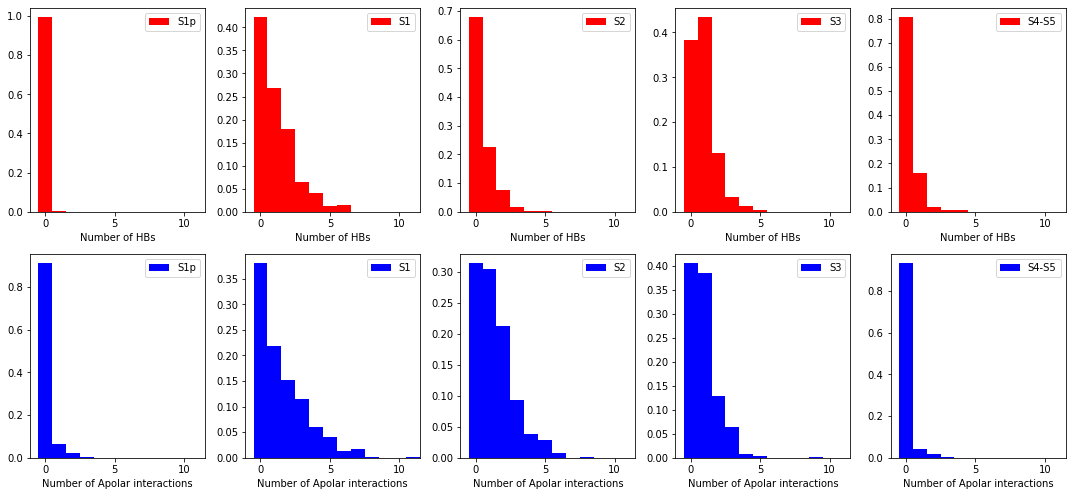

In [13]:
# Histograms of number of bonds, per site
xmin=0-.5
xmax=11+.5
bins=12

fig = plt.figure(figsize=(15,7))
ax = fig.subplots(2,5)
# Use the index arrays to select the atoms of each site
ax[0,0].hist(np.sum(dataHB[S1p_indx], axis=1),range=(xmin, xmax), bins=bins, label='S1p',color='r',density=True)
ax[0,1].hist(np.sum(dataHB[S1_indx], axis=1),range=(xmin, xmax),label='S1',bins=bins, color='r', density=True)
ax[0,2].hist(np.sum(dataHB[S2_indx], axis=1),range=(xmin, xmax),label='S2',bins=bins, color='r', density=True)
ax[0,3].hist(np.sum(dataHB[S3_indx], axis=1),range=(xmin, xmax),label='S3', bins=bins, color='r',density=True)
ax[0,4].hist(np.sum(dataHB[S45_indx], axis=1),range=(xmin, xmax),label='S4-S5',bins=bins, color='r', density=True)

for i in range(5):
    ax[0,i].set_xlabel("Number of HBs")
    ax[0,i].legend()
    ax[0,i].set_xlim(xmax=xmax)

ax[1,0].hist(np.sum(dataAB[S1p_indx], axis=1),range=(xmin, xmax), bins=bins, label='S1p',color='b',density=True)
ax[1,1].hist(np.sum(dataAB[S1_indx], axis=1),range=(xmin, xmax),label='S1',bins=bins, color='b', density=True)
ax[1,2].hist(np.sum(dataAB[S2_indx], axis=1),range=(xmin, xmax),label='S2',bins=bins, color='b', density=True)
ax[1,3].hist(np.sum(dataAB[S3_indx], axis=1),range=(xmin, xmax),label='S3', bins=bins, color='b',density=True)
ax[1,4].hist(np.sum(dataAB[S45_indx], axis=1),range=(xmin, xmax),label='S4-S5',bins=bins, color='b', density=True)

for i in range(5):
    ax[1,i].set_xlabel("Number of Apolar interactions")
    ax[1,i].legend()
    ax[1,i].set_xlim(xmax=xmax)

    
    
plt.tight_layout()
fig.savefig('ena_HBs.png', dpi=300)

In [14]:
# Sum Hydrogen bond and halogen bond data frames to get a general "Polar Bonds" dataframe
dataPB = dataHB + dataHaB

In [15]:
dataPB

,218,219,220,223,224,225,226,230,231,375,...,1819,1822,1823,1824,2896,2897,2900,2901,2902,2903
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


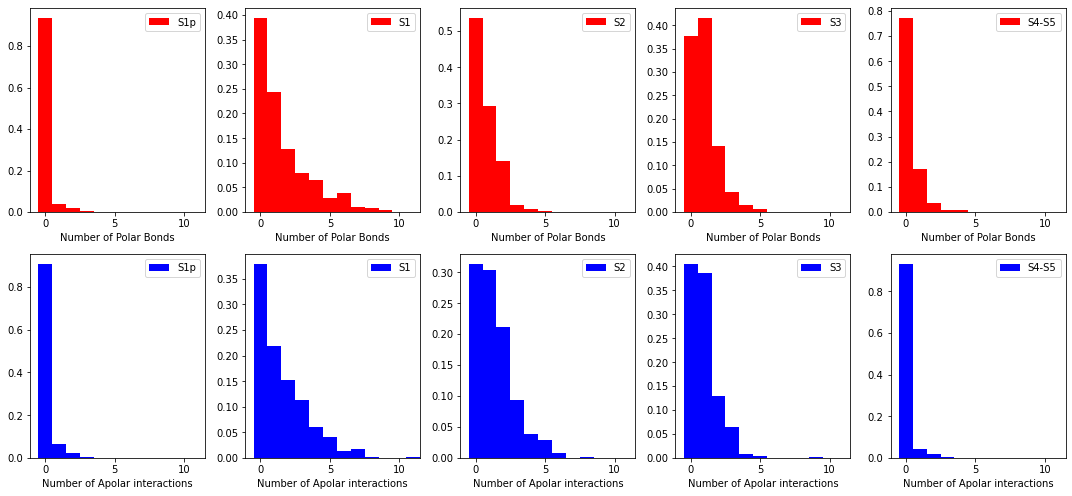

In [16]:
# Same as before but with the newly defined data frame
xmin=0-.5
xmax=11+.5
bins=12

fig = plt.figure(figsize=(15,7))
ax = fig.subplots(2,5)
ax[0,0].hist(np.sum(dataPB[S1p_indx], axis=1),range=(xmin, xmax), bins=bins, label='S1p',color='r',density=True)
ax[0,1].hist(np.sum(dataPB[S1_indx], axis=1),range=(xmin, xmax),label='S1',bins=bins, color='r', density=True)
ax[0,2].hist(np.sum(dataPB[S2_indx], axis=1),range=(xmin, xmax),label='S2',bins=bins, color='r', density=True)
ax[0,3].hist(np.sum(dataPB[S3_indx], axis=1),range=(xmin, xmax),label='S3', bins=bins, color='r',density=True)
ax[0,4].hist(np.sum(dataPB[S45_indx], axis=1),range=(xmin, xmax),label='S4-S5',bins=bins, color='r', density=True)

for i in range(5):
    ax[0,i].set_xlabel("Number of Polar Bonds")
    ax[0,i].legend()
    ax[0,i].set_xlim(xmax=xmax)

ax[1,0].hist(np.sum(dataAB[S1p_indx], axis=1),range=(xmin, xmax), bins=bins, label='S1p',color='b',density=True)
ax[1,1].hist(np.sum(dataAB[S1_indx], axis=1),range=(xmin, xmax),label='S1',bins=bins, color='b', density=True)
ax[1,2].hist(np.sum(dataAB[S2_indx], axis=1),range=(xmin, xmax),label='S2',bins=bins, color='b', density=True)
ax[1,3].hist(np.sum(dataAB[S3_indx], axis=1),range=(xmin, xmax),label='S3', bins=bins, color='b',density=True)
ax[1,4].hist(np.sum(dataAB[S45_indx], axis=1),range=(xmin, xmax),label='S4-S5',bins=bins, color='b', density=True)

for i in range(5):
    ax[1,i].set_xlabel("Number of Apolar interactions")
    ax[1,i].legend()
    ax[1,i].set_xlim(xmax=xmax)

    
    
plt.tight_layout()
fig.savefig('ena_PBs.png', dpi=300)

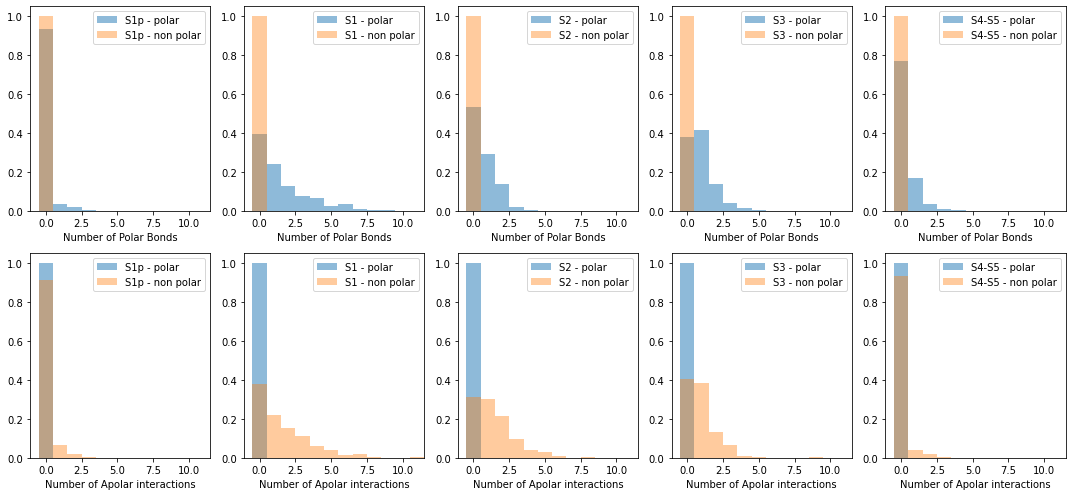

In [17]:
# NOT VERY INFORMATIVE
# Same as before but with the additional splitting per polar/apolar region within each site
xmin=0-.5
xmax=11+.5
bins=12

fig = plt.figure(figsize=(15,7))
ax = fig.subplots(2,5)

#S1p
x = np.sum(dataPB[mappa[(mappa['site'] == 'S1p') & (mappa['isPHOB'] == False) ]['idx0'] ], axis=1)
xx = np.sum(dataPB[mappa[(mappa['site'] == 'S1p') & (mappa['isPHOB'] == True) ]['idx0'] ], axis=1)
ax[0,0].hist(x, range=(xmin, xmax), bins=bins, label='S1p - polar', alpha=0.5,density=True)
ax[0,0].hist(xx, range=(xmin, xmax), bins=bins, label='S1p - non polar', alpha=0.4,density=True)
# S1
x = np.sum(dataPB[mappa[(mappa['site'] == 'S1') & (mappa['isPHOB'] == False) ]['idx0'] ], axis=1)
xx = np.sum(dataPB[mappa[(mappa['site'] == 'S1') & (mappa['isPHOB'] == True) ]['idx0'] ], axis=1)
ax[0,1].hist(x, range=(xmin, xmax), bins=bins, label='S1 - polar', alpha=0.5,density=True)
ax[0,1].hist(xx, range=(xmin, xmax), bins=bins, label='S1 - non polar', alpha=0.4,density=True)
# S2
x = np.sum(dataPB[mappa[(mappa['site'] == 'S2') & (mappa['isPHOB'] == False) ]['idx0'] ], axis=1)
xx = np.sum(dataPB[mappa[(mappa['site'] == 'S2') & (mappa['isPHOB'] == True) ]['idx0'] ], axis=1)
ax[0,2].hist(x, range=(xmin, xmax), bins=bins, label='S2 - polar', alpha=0.5,density=True)
ax[0,2].hist(xx, range=(xmin, xmax), bins=bins, label='S2 - non polar', alpha=0.4,density=True)
# S3
x = np.sum(dataPB[mappa[(mappa['site'] == 'S3') & (mappa['isPHOB'] == False) ]['idx0'] ], axis=1)
xx = np.sum(dataPB[mappa[(mappa['site'] == 'S3') & (mappa['isPHOB'] == True) ]['idx0'] ], axis=1)
ax[0,3].hist(x, range=(xmin, xmax), bins=bins, label='S3 - polar',  alpha=0.5,density=True)
ax[0,3].hist(xx, range=(xmin, xmax), bins=bins, label='S3 - non polar', alpha=0.4,density=True)
# S4-S5
x = np.sum(dataPB[mappa[(mappa['site'] == 'S4-S5') & (mappa['isPHOB'] == False) ]['idx0'] ], axis=1)
xx = np.sum(dataPB[mappa[(mappa['site'] == 'S4-S5') & (mappa['isPHOB'] == True) ]['idx0'] ], axis=1)
ax[0,4].hist(x, range=(xmin, xmax), bins=bins, label='S4-S5 - polar',  alpha=0.5,density=True)
ax[0,4].hist(xx, range=(xmin, xmax), bins=bins, label='S4-S5 - non polar', alpha=0.4,density=True)

for i in range(5):
    ax[0,i].set_xlabel("Number of Polar Bonds")
    ax[0,i].legend()
    ax[0,i].set_xlim(xmax=xmax)

#S1p
x = np.sum(dataAB[mappa[(mappa['site'] == 'S1p') & (mappa['isPHOB'] == False) ]['idx0'] ], axis=1)
xx = np.sum(dataAB[mappa[(mappa['site'] == 'S1p') & (mappa['isPHOB'] == True) ]['idx0'] ], axis=1)
ax[1,0].hist(x, range=(xmin, xmax), bins=bins, label='S1p - polar', alpha=0.5,density=True)
ax[1,0].hist(xx, range=(xmin, xmax), bins=bins, label='S1p - non polar', alpha=0.4,density=True)
# S1
x = np.sum(dataAB[mappa[(mappa['site'] == 'S1') & (mappa['isPHOB'] == False) ]['idx0'] ], axis=1)
xx = np.sum(dataAB[mappa[(mappa['site'] == 'S1') & (mappa['isPHOB'] == True) ]['idx0'] ], axis=1)
ax[1,1].hist(x, range=(xmin, xmax), bins=bins, label='S1 - polar', alpha=0.5,density=True)
ax[1,1].hist(xx, range=(xmin, xmax), bins=bins, label='S1 - non polar', alpha=0.4,density=True)
# S2
x = np.sum(dataAB[mappa[(mappa['site'] == 'S2') & (mappa['isPHOB'] == False) ]['idx0'] ], axis=1)
xx = np.sum(dataAB[mappa[(mappa['site'] == 'S2') & (mappa['isPHOB'] == True) ]['idx0'] ], axis=1)
ax[1,2].hist(x, range=(xmin, xmax), bins=bins, label='S2 - polar',  alpha=0.5,density=True)
ax[1,2].hist(xx, range=(xmin, xmax), bins=bins, label='S2 - non polar', alpha=0.4,density=True)
# S3
x = np.sum(dataAB[mappa[(mappa['site'] == 'S3') & (mappa['isPHOB'] == False) ]['idx0'] ], axis=1)
xx = np.sum(dataAB[mappa[(mappa['site'] == 'S3') & (mappa['isPHOB'] == True) ]['idx0'] ], axis=1)
ax[1,3].hist(x, range=(xmin, xmax), bins=bins, label='S3 - polar',  alpha=0.5,density=True)
ax[1,3].hist(xx, range=(xmin, xmax), bins=bins, label='S3 - non polar', alpha=0.4,density=True)
# S4-S5
x = np.sum(dataAB[mappa[(mappa['site'] == 'S4-S5') & (mappa['isPHOB'] == False) ]['idx0'] ], axis=1)
xx = np.sum(dataAB[mappa[(mappa['site'] == 'S4-S5') & (mappa['isPHOB'] == True) ]['idx0'] ], axis=1)
ax[1,4].hist(x, range=(xmin, xmax), bins=bins, label='S4-S5 - polar',  alpha=0.5,density=True)
ax[1,4].hist(xx, range=(xmin, xmax), bins=bins, label='S4-S5 - non polar', alpha=0.4,density=True)


for i in range(5):
    ax[1,i].set_xlabel("Number of Apolar interactions")
    ax[1,i].legend()
    ax[1,i].set_xlim(xmax=xmax)

    
    
plt.tight_layout()
fig.savefig('sub_pockets.png', dpi=300)

In [18]:
# Define the bad/unclassified contacts
# by subtracting from close contacts both polar and apolar bonds 
bad = data - dataPB
bad = bad - dataAB


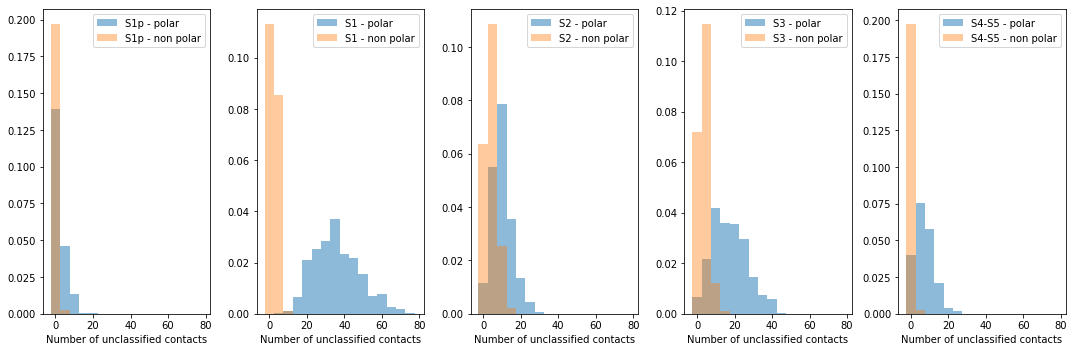

In [19]:
# Represent the bad/unclassified contact for each apolar and polar regions of each site
xmin=0-2.5
xmax=80+2.5
bins=17

fig = plt.figure(figsize=(15,5))
ax = fig.subplots(1,5)

#S1p
x = np.sum(bad[mappa[(mappa['site'] == 'S1p') & (mappa['isPHOB'] == False) ]['idx0'] ], axis=1)
xx = np.sum(bad[mappa[(mappa['site'] == 'S1p') & (mappa['isPHOB'] == True) ]['idx0'] ], axis=1)
ax[0].hist(x, range=(xmin, xmax), bins=bins, label='S1p - polar', alpha=0.5,density=True)
ax[0].hist(xx, range=(xmin, xmax), bins=bins, label='S1p - non polar', alpha=0.4,density=True)
# S1
x = np.sum(bad[mappa[(mappa['site'] == 'S1') & (mappa['isPHOB'] == False) ]['idx0'] ], axis=1)
xx = np.sum(bad[mappa[(mappa['site'] == 'S1') & (mappa['isPHOB'] == True) ]['idx0'] ], axis=1)
ax[1].hist(x, range=(xmin, xmax), bins=bins, label='S1 - polar', alpha=0.5,density=True)
ax[1].hist(xx, range=(xmin, xmax), bins=bins, label='S1 - non polar', alpha=0.4,density=True)
# S2
x = np.sum(bad[mappa[(mappa['site'] == 'S2') & (mappa['isPHOB'] == False) ]['idx0'] ], axis=1)
xx = np.sum(bad[mappa[(mappa['site'] == 'S2') & (mappa['isPHOB'] == True) ]['idx0'] ], axis=1)
ax[2].hist(x, range=(xmin, xmax), bins=bins, label='S2 - polar', alpha=0.5,density=True)
ax[2].hist(xx, range=(xmin, xmax), bins=bins, label='S2 - non polar', alpha=0.4,density=True)
# S3
x = np.sum(bad[mappa[(mappa['site'] == 'S3') & (mappa['isPHOB'] == False) ]['idx0'] ], axis=1)
xx = np.sum(bad[mappa[(mappa['site'] == 'S3') & (mappa['isPHOB'] == True) ]['idx0'] ], axis=1)
ax[3].hist(x, range=(xmin, xmax), bins=bins, label='S3 - polar',  alpha=0.5,density=True)
ax[3].hist(xx, range=(xmin, xmax), bins=bins, label='S3 - non polar', alpha=0.4,density=True)
# S4-S5
x = np.sum(bad[mappa[(mappa['site'] == 'S4-S5') & (mappa['isPHOB'] == False) ]['idx0'] ], axis=1)
xx = np.sum(bad[mappa[(mappa['site'] == 'S4-S5') & (mappa['isPHOB'] == True) ]['idx0'] ], axis=1)
ax[4].hist(x, range=(xmin, xmax), bins=bins, label='S4-S5 - polar',  alpha=0.5,density=True)
ax[4].hist(xx, range=(xmin, xmax), bins=bins, label='S4-S5 - non polar', alpha=0.4,density=True)

for i in range(5):
    ax[i].set_xlabel("Number of unclassified contacts")
    ax[i].legend()
    ax[i].set_xlim(xmax=xmax)

 
    
plt.tight_layout()
fig.savefig('sub_pock_bad.png', dpi=300)

## Analyses that I didn't show during the last meeting

In [20]:
# Sum Apolar and Polar interactions
good = dataAB + dataPB

In [21]:
good

,218,219,220,223,224,225,226,230,231,375,...,1819,1822,1823,1824,2896,2897,2900,2901,2902,2903
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Define a new dataframe where you sum info per residue
ress = list()
for a,b in zip(mappa[['res_name', 'res_num']].sort_values(by=['res_num']).drop_duplicates(keep='first')['res_name'].values,mappa[['res_name', 'res_num']].sort_values(by=['res_num']).drop_duplicates(keep='first')['res_num'].values):
    name = a+'_'+str(b)
    ress.append(name)

perres = pd.DataFrame()

for c in ress:
    r = c.split('_')[1]
    # number of "good" interactions per residue
    perres[c] = np.sum( good[mappa[(mappa['res_num'] == int(r) )]['idx0']]  ,axis=1)
perres.reset_index(drop=True, inplace=True)

In [23]:
perres

,THR_25,THR_26,HSD_41,VAL_42,MET_49,TYR_54,ASN_119,PHE_140,LEU_141,ASN_142,...,PRO_168,HSE_172,PHE_185,ASP_187,ARG_188,GLN_189,THR_190,ALA_191,GLN_192,SER_307
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Drop residues that make zero polar/apolar interactions
perres2 = perres[perres.columns[perres.sum(axis=0) != 0]]
## These are the dropped columns 
display(sorted(perres.columns[perres.sum(axis=0) == 0]))

['ALA_191', 'ASN_119', 'PHE_185', 'SER_307', 'VAL_42']

In [25]:
# Compute mean, std dev, min and max for the number of contacts
desc = perres2.describe().iloc[[1,2,3,7]].T.sort_values(by=['mean'], ascending=False)
desc = desc[['mean', 'std', 'min','max']]

In [26]:
desc

,mean,std,min,max
GLU_166,1.826,1.754389,0.0,10.0
GLN_189,0.732,0.890934,0.0,4.0
MET_165,0.632,0.844988,0.0,5.0
TYR_54,0.582,0.785181,0.0,5.0
MET_49,0.564,0.706330,0.0,3.0
HSD_41,0.544,0.716303,0.0,3.0
CYS_145,0.380,0.586761,0.0,3.0
ASP_187,0.328,0.533841,0.0,2.0
ARG_188,0.214,0.473976,0.0,3.0
HSE_164,0.212,0.446604,0.0,3.0


<AxesSubplot:>

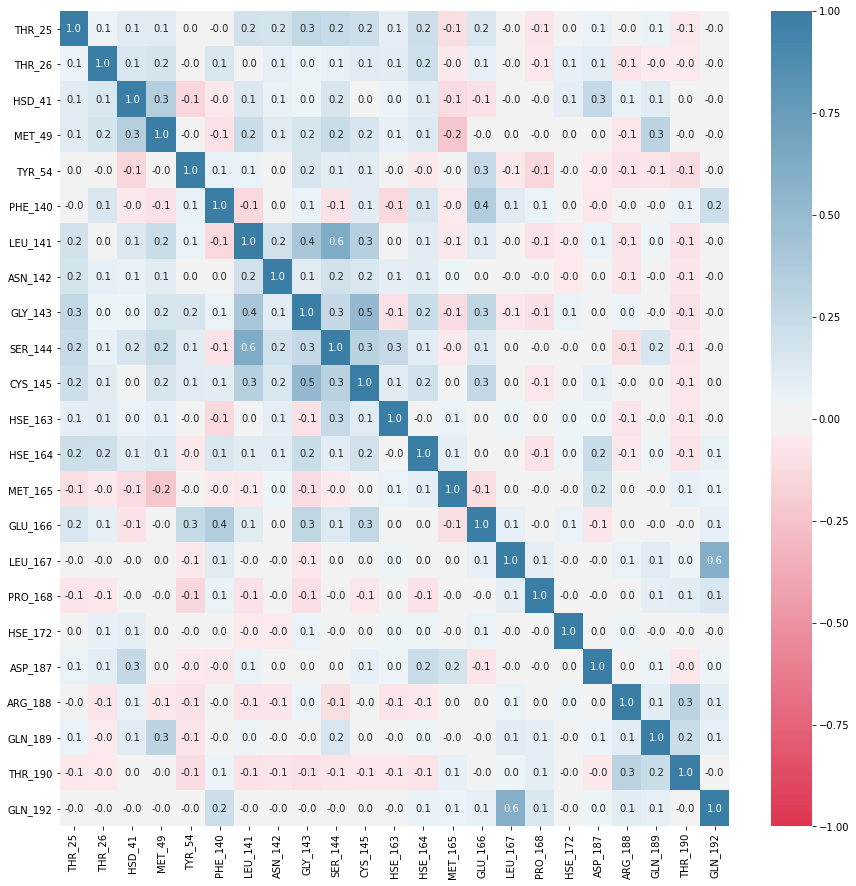

In [27]:
# Comute correlation between the apolar/polar contacts made by each residue
fig = plt.figure(figsize=(15,15) )
cmap = sns.diverging_palette( 7, 236, s=80, l=50, as_cmap=True)
sns.heatmap(perres2.corr(), vmin=-1, vmax=1, cmap=cmap, annot=True,fmt='.1f')
#fig.savefig()